In [55]:
import os
import utility
import torch
import torch.nn as nn
from importlib import import_module
import datetime
import torch.optim as optim
from models import *
import models
from data.datasets import *
from trainers.distiller import Distiller
import losses

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
from torchinfo import summary

In [56]:
class trainArgs:
    gpu_id = 0
    net = 'STMFNet'
    data_dir = 'D:/stmfnet_data'
    out_dir = './train_results'
    load = None
    epochs = 70
    batch_size = 2
    loss = "1*Lap"
    patch_size = 256
    lr = 0.001
    lr_decay = 20
    decay_type = 'step'
    gamma = 0.5
    patience = None
    optimizer = 'ADAMax'
    weight_decay = 0
    featc = [64, 128, 256, 512]
    featnet = 'UMultiScaleResNext'
    featnorm = 'batch'
    kernel_size = 5
    dilation = 1
    finetune_pwc = False
    temp = 10
    alpha = 0.3
    distill_loss_fn = 'KLDivLoss'

args=trainArgs()

In [57]:
from data.datasets import *
from torch.utils.data import DataLoader

torch.cuda.set_device(args.gpu_id)

# training sets
vimeo90k_train = Vimeo90k_quintuplet(
    join(args.data_dir, "vimeo_septuplet"),
    train=True,
    crop_sz=(args.patch_size, args.patch_size),
)
bvidvc_train = BVIDVC_quintuplet(
    join(args.data_dir, "bvidvc"), crop_sz=(args.patch_size, args.patch_size)
)

# validation set
vimeo90k_valid = Vimeo90k_quintuplet(
    join(args.data_dir, "vimeo_septuplet"),
    train=False,
    crop_sz=(args.patch_size, args.patch_size),
    augment_s=False,
    augment_t=False,
)

datasets_train = [bvidvc_train]
train_sampler = Sampler(datasets_train, iter=True)

# data loaders
train_loader = DataLoader(
    dataset=train_sampler, batch_size=args.batch_size, shuffle=True, num_workers=0
)
valid_loader = DataLoader(
    dataset=vimeo90k_valid, batch_size=args.batch_size, num_workers=0
)

In [58]:
# Load the model


torch.cuda.set_device(args.gpu_id)

if not os.path.exists(args.out_dir):
    os.mkdir(args.out_dir)

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# def load_model(filepath):

#     checkpoint = torch.load(filepath)
#     model = STMFNet(args).cuda()
#     model.load_state_dict(checkpoint['state_dict'])
    
#     return model

# model = load_model("./models/stmfnet.pth")

teacher = to_device(STMFNet(args), device)
teacher.to(device)
checkpoint = torch.load('./models/stmfnet.pth')
teacher.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### define student model

In [59]:
st1 = to_device(STMFNet(args), device)
st1.to(device)
checkpoint1 = torch.load('./train_results/checkpoint/model_epoch001.pth')
st1.load_state_dict(checkpoint1['state_dict'])

st2 = to_device(STMFNet(args), device)
st2.to(device)
checkpoint2 = torch.load('./train_results/checkpoint/model_epoch008.pth')
st2.load_state_dict(checkpoint2['state_dict'])


<All keys matched successfully>

### distill

In [65]:
def getmax():
    nums = []
    for file in os.listdir('./train_results/checkpoint'):
        if file.endswith('.pth'):
            nums.append(int(file.split('_epoch')[-1].split('.')[0]))
    return max(nums)

getmax()

9

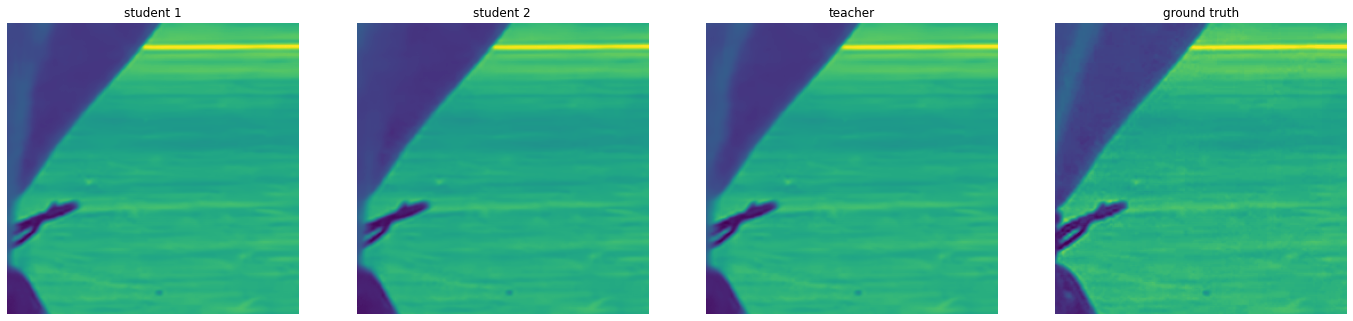

In [66]:
it_1 = next(iter(train_loader))

# for batch_idx, (frame1, frame3, frame4, frame5, frame7) in enumerate(train_loader, 1):
# optimizer.zero_grad()

frame1 = it_1[0].cuda()
frame3 = it_1[1].cuda()
frame4 = it_1[2].cuda()
frame5 = it_1[3].cuda()
frame7 = it_1[4].cuda()

import losses
output1 = st1(frame1, frame3, frame5, frame7)
output2 = st2(frame1, frame3, frame5, frame7)
targets = teacher(frame1, frame3, frame5, frame7)

fig, ax = plt.subplot_mosaic([
    ['student1', 'student2','teacher', 'ground truth'],
], figsize=(24, 10))
fig.patch.set_facecolor('xkcd:white')
ax['student1'].imshow(output1['frame1'][0, 0, :, :].cpu().detach().numpy())
ax['student1'].set_title('student 1')
ax['student1'].axis('off')

ax['student2'].imshow(output2['frame1'][0, 0, :, :].cpu().detach().numpy())
ax['student2'].set_title('student 2')
ax['student2'].axis('off')

ax['teacher'].imshow(targets['frame1'][0, 0, :, :].cpu().detach().numpy())
ax['teacher'].set_title('teacher')
ax['teacher'].axis('off')

ax['ground truth'].imshow(frame4[0, 0, :, :].cpu().detach().numpy())
ax['ground truth'].set_title('ground truth')
ax['ground truth'].axis('off')

plt.show()
torch.cuda.empty_cache()

In [67]:
from data import testsets

class testArgs:
    gpu_id = 0
    net = 'STMFNet'
    dataset = 'Ucf101_quintuplet'
    metrics = ['PSNR', 'SSIM']
    checkpoint = './train_results/checkpoint/model_epoch008.pth'
    # checkpoint = './models/stmfnet.pth'
    data_dir = 'D:/stmfnet_data'
    out_dir = './tests/results'
    featc = [64, 128, 256, 512]
    featnet = 'UMultiScaleResNext'
    featnorm = 'batch'
    kernel_size = 5
    dilation = 1
    finetune_pwc = False

args = testArgs()


densities = {}
for i in range(getmax()):
    model = to_device(STMFNet(args), device)
    model.to(device)
    model_name = "model_epoch" + str(i+1).zfill(3)
    model_path = "./train_results/checkpoint/" + model_name + ".pth"
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['state_dict'])

    weights = [w for name, w in model.named_parameters() if "weight" in name]
    num_features = sum([w.numel() for w in weights])
    density = sum([torch.sum(w != 0).item() for w in weights]) / num_features
    print(density)
    densities[str(i+1).zfill(3)] = density

    # test_dir = os.path.join(args.out_dir, args.dataset)
    # if args.dataset.split("_")[0] in ["VFITex", "Ucf101", "Davis90"]:
    #     db_folder = args.dataset.split("_")[0].lower()
    # else:
    #     db_folder = args.dataset.lower()
    # test_db = getattr(testsets, args.dataset)(os.path.join(args.data_dir, db_folder))
    # if not os.path.exists(test_dir):
    #     os.mkdir(test_dir)

    # test_db.eval(model, metrics=args.metrics, output_dir=test_dir)

0.9309851931552096
0.888647523805175
0.8539292341085717
0.833482455180953
0.8154009450885759
0.7982379735186073
0.7817336584921293
0.7658213391864075
0.7504149279103675


In [68]:
avg_PSNR_results = {
    '001':33.395,
    '002':30.383,
    '003':33.388,
    '004':33.398,
    '005':33.4,
    '006':33.359,
    '007':33.366,
    '008':33.361,
    '009':33.324,
}

In [69]:
import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import pandas as pd

data = pd.DataFrame(list(densities.items()), columns=['epoch', 'density'])
data['PSNR'] = list(avg_PSNR_results.values())
data.sort_values(by='density', inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data['density'],
                         y=data['PSNR'],
                         mode='lines+markers',
                         name='PSNR',
                         text=data['epoch'],
                         hoverinfo='x+y+text'))
fig.update_xaxes(range=[0.2, 1])
fig.show()

Model Summary

In [71]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = to_device(STMFNet(args), device)
# model.to(device)
# model_path = "./train_results/checkpoint/model_epoch008.pth"
# checkpoint = torch.load(model_path)

# model.load_state_dict(checkpoint['state_dict'])

# x = summary(model, [(2, 3, 256, 256), (2, 3, 256, 256), (2, 3, 256, 256), (2, 3, 256, 256)])

# with open('./summaries/'+model_name+'.txt', 'w') as f:
#     f.write(str(x))
#     f.close()